In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imutils
import imutils.paths as path
from pandas import DataFrame
import pathlib
import glob
from skimage.feature import greycomatrix, greycoprops
from skimage.transform import rescale

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
L = 256

def getAngledGLCM(gray, alpha):
    row, col = gray.shape
    glcm = np.zeros((L, L), np.uint8)
    xy = [0, 0]
    rowStart = 0
    colStart = 0
    rowEnd = row
    colEnd = col - 1

    if alpha == 0:
        xy = [0, 1]
    elif alpha == 45:
        xy = [-1, 1]
        rowStart = 1
        colStart = 0
    elif alpha == 90:
        xy = [-1, 0]
        rowStart = 1
        colEnd = col
    else:
        xy = [-1, -1]
        rowStart = 1
        colStart = 1
        colEnd = col

    for x in range(rowStart, rowEnd):
        for y in range(colStart, colEnd):
            pixVal = gray[x, y]
            pixValNeighbor = gray[x + xy[0], y + xy[1]]
            glcm[pixVal, pixValNeighbor] += 1

    return glcm / glcm.sum()


def getGLCM(gray, alpha):
    # alpha = 0

    # for i in range(4):
    glcm = getAngledGLCM(gray, alpha)
    # alpha += 45

    return glcm


def getSumGLCM(glcm):
    sumX = []
    sumY = []

    for i in range(L):
        sumY.append(glcm[:, i].sum())
        sumX.append(glcm[i, :].sum())

    return [sumX, sumY]


def getMean(glcm, sumX, sumY):
    # sumX, sumY = getSumGLCM(glcm)
    meanX = 0.0
    meanY = 0.0

    for i in range(L):
        meanX += i * sumX[i]
        meanY += i * sumY[i]

    return [meanX, meanY]

def getVarianceXY(glcm, sumX, sumY, meanX, meanY):
    # meanX, meanY = getMean(glcm)
    # sumX, sumY = getSumGLCM(glcm)
    varX = 0.0
    varY = 0.0

    for i in range(L):
        varX += ((i - meanX) ** 2) * sumX[i]
        varY += ((i - meanY) ** 2) * sumY[i]

    return [varX, varY]


def getStandardDeviation(varX, varY):
    # varX, varY = getVarianceXY(glcm)

    return [np.sqrt(varX), np.sqrt(varY)]


def getASM(glcm):
    return np.power(glcm.flatten(), 2).sum()


def getContrast(glcm):
    con = 0.0

    for x in range(L):
        for y in range(L):
            con += ((x - y) ** 2) * glcm[x, y]

    return con


def getCorrelation(glcm, meanX, meanY, sdX, sdY):
    cor = 0.0
    # meanX, meanY = getMean(glcm)
    # sdX, sdY = getStandardDeviation(glcm)

    for x in range(L):
        for y in range(L):
            cor += (x * y) * glcm[x, y]

    return (cor - (meanX * meanY)) / (sdX * sdY)


def getIDM(glcm):
    idm = 0.0
  
    for x in range(L):
        for y in range(L):
            idm += glcm[x, y] / (1 + ((x - y) ** 2))

    return idm

In [ ]:
data_path = '/content/drive/MyDrive/DATAA'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

dict = {}
label = []
properties = ['asm', 'contrast', 'correlation', 'idm']
columns = []
angles = ['0', '45', '90', '135']
for name in properties:
    for ang in angles:
        columns.append(name + "_" + ang)
columns.append("label")

test = pd.DataFrame()

res = []

In [ ]:
for category in categories:
    folder_path=os.path.join(data_path, category)
    img_names=os.listdir(folder_path)
    for img_name in img_names:
        img_path=os.path.join(folder_path, img_name)
        # for i in tqdm(img_path, desc="load"):
        img = cv2.imread(img_path)
        resize = imutils.resize(img, width=128, height=128)
        #hsv= cv2.cvtColor(resize, cv2.COLOR_BGR2HSV)
        gray= cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
        #gamma_two_point_two = np.array(255*(gray/255)**1.5,dtype='uint8')
        #img3 = cv2.hconcat([gamma_two_point_two])
        glcm = np.zeros((L, L), np.float64)
        # label.append(label_dict[category])
        alpha = 0
        dict = {}
        dict['label'] = label_dict[category]

        for i in range(4):
            glcm = getGLCM(gray, alpha)
            sumX, sumY = getSumGLCM(glcm)
            meanX, meanY = getMean(glcm, sumX, sumY)
            varX, varY = getVarianceXY(glcm, sumX, sumY, meanX, meanY)
            sdX, sdY = getStandardDeviation(varX, varY)
            mean = [meanX, meanY]
            asm = getASM(glcm)
            contrast = getContrast(glcm)
            correlation = getCorrelation(glcm, meanX, meanY, sdX, sdY)
            idm = getIDM(glcm)

            dict["asm_{}".format(alpha)] = asm
            dict["contrast_{}".format(alpha)] = contrast
            dict["correlation_{}".format(alpha)] = correlation
            dict["idm_{}".format(alpha)] = idm
            alpha += 45

        res.append(dict)

In [ ]:
glcm_df = pd.DataFrame(res)

In [ ]:
# train test splitting
y = glcm_df['label']
X = glcm_df.drop(columns='label')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#prepare naive bayes
clf = GaussianNB()
#clf = MultinomialNB()
#clf = BernoulliNB()
y_pred = clf.fit(X_train, y_train).predict(X_test)

cnf = confusion_matrix(y_test, y_pred)
print(cnf)

[[7 2 0]
 [2 5 1]
 [0 4 6]]


In [ ]:
print(f'Akurasi: {accuracy_score(y_test, y_pred):.2%}')
print(classification_report(y_test, y_pred))

Akurasi: 66.67%
              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.45      0.62      0.53         8
           2       0.86      0.60      0.71        10

    accuracy                           0.67        27
   macro avg       0.70      0.67      0.67        27
weighted avg       0.71      0.67      0.68        27



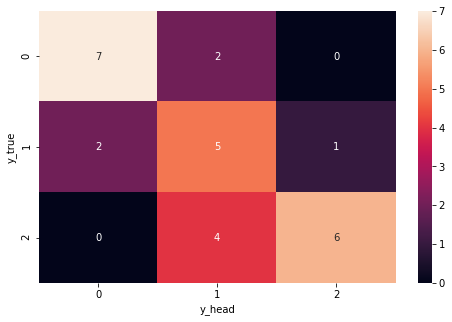

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

In [ ]:
import pickle
pickle.dump(clf, open('model_training.sav', 'wb'))